In [2]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import glob
import fitsio
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter, NullFormatter
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['legend.fontsize'] = 12
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from mockfactory import utils, DistanceToRedshift, Catalog, RandomBoxCatalog
from cosmoprimo.fiducial import DESI, AbacusSummit
from pycorr import TwoPointCorrelationFunction
from pycorr import project_to_multipoles, project_to_wp
from pypower import CatalogFFTPower, PowerSpectrumMultipoles, setup_logging
from pyrecon import MultiGridReconstruction, IterativeFFTReconstruction, IterativeFFTParticleReconstruction, utils, setup_logging

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
sys.path.append('/global/homes/s/shengyu/project_rc/main/Y3/')
from helper import REDSHIFT_VSMEAR, REDSHIFT_CUBICBOX, EDGES, RSF_CUBIC_ERROR, RSF_COV_ERROR, RSF_EZMOCKS_ERROR, GET_RECON_BIAS
from helper import REDSHIFT_LSS_VSMEAR, REDSHIFT_LSS_CUBICBOX, COLOR_TRACERS, Y3_EFFECTIVE_VOLUME
from fit_cubic_tools import load_bins, load_rescalc_cov, load_mock_cov, load_EZcov_fn
%load_ext autoreload
%autoreload 2
     
Z_VSMEAR = REDSHIFT_LSS_VSMEAR # REDSHIFT_VSMEAR or REDSHIFT_LSS_VSMEAR (LSS z bins)
Z_CUBIC = REDSHIFT_LSS_CUBICBOX # REDSHIFT_CUBICBOX or REDSHIFT_LSS_CUBICBOX

def select_bk_range(k, bk, kmin, kmax):
    mask = (k >= kmin) & (k <= kmax)
    return k[mask], bk[mask]

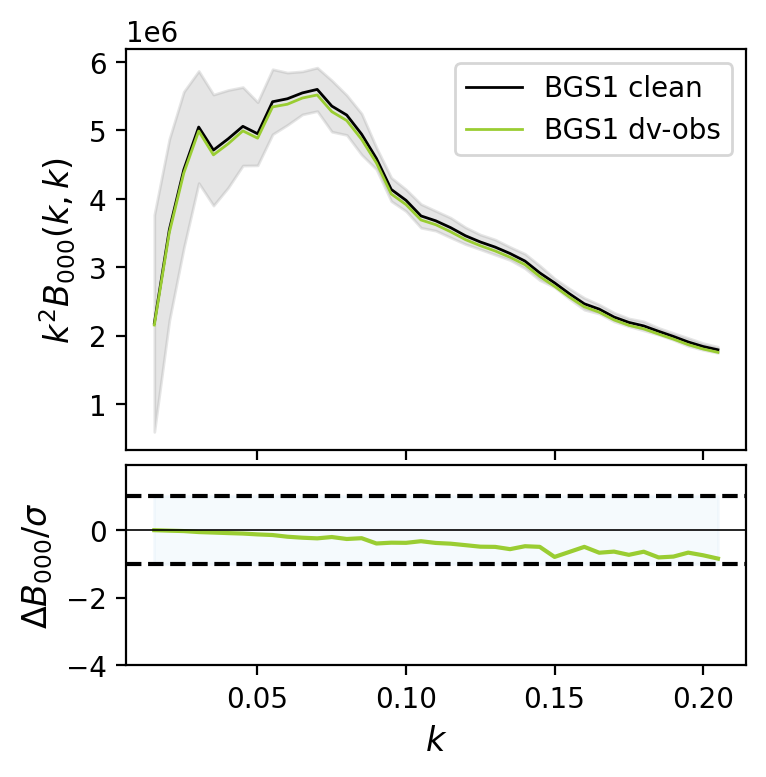

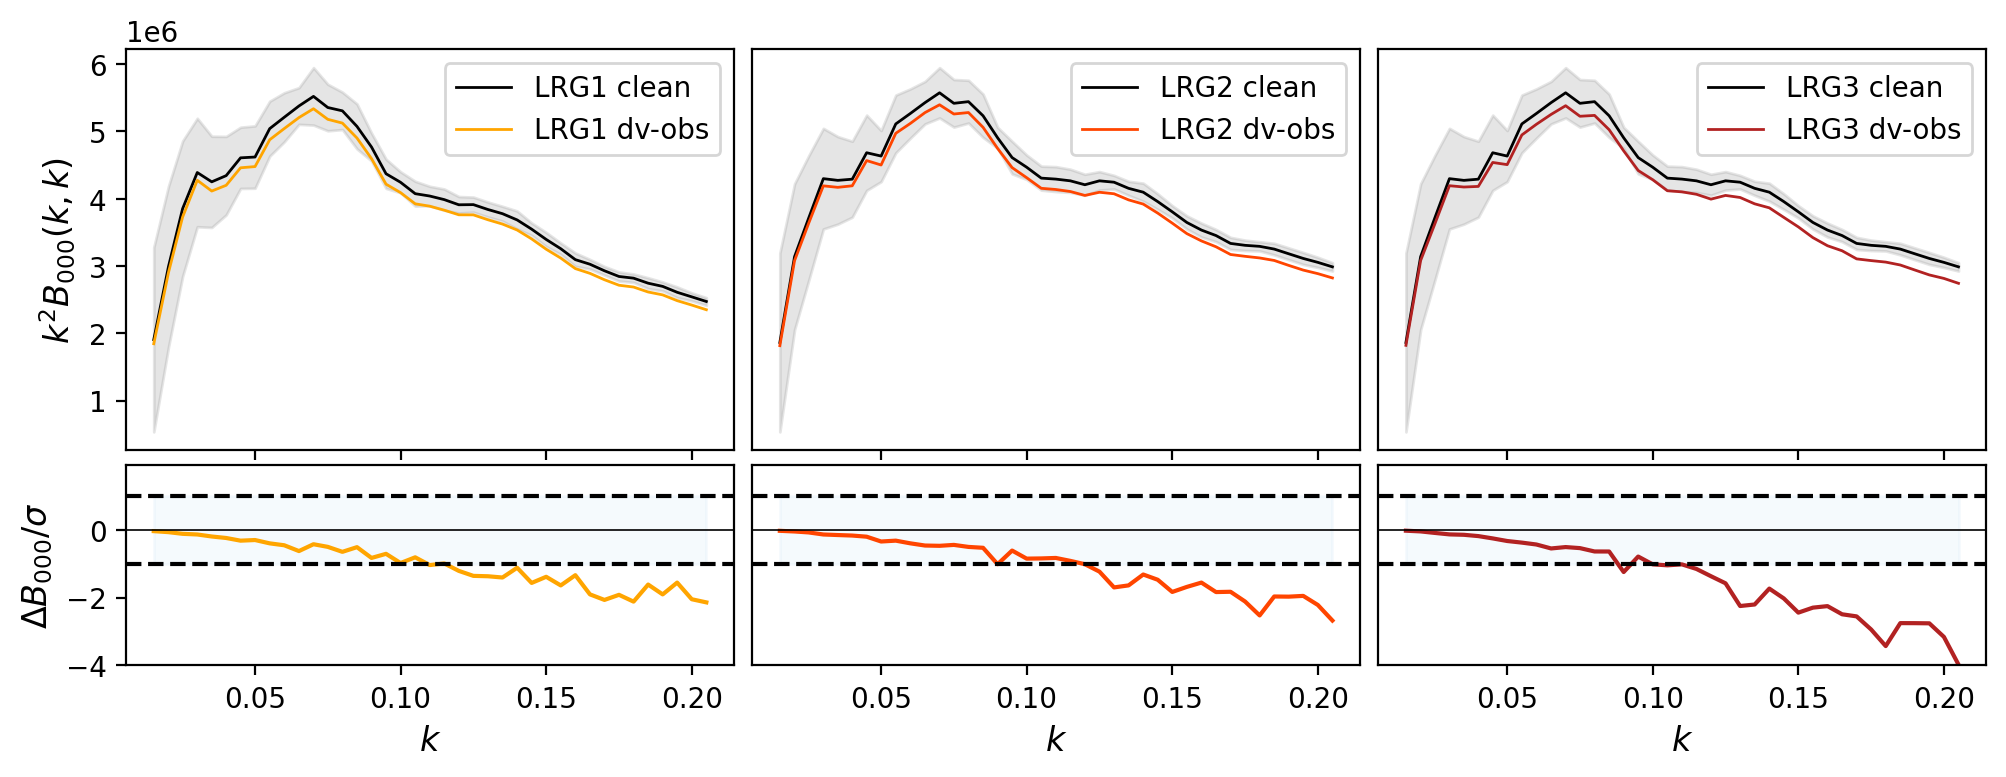

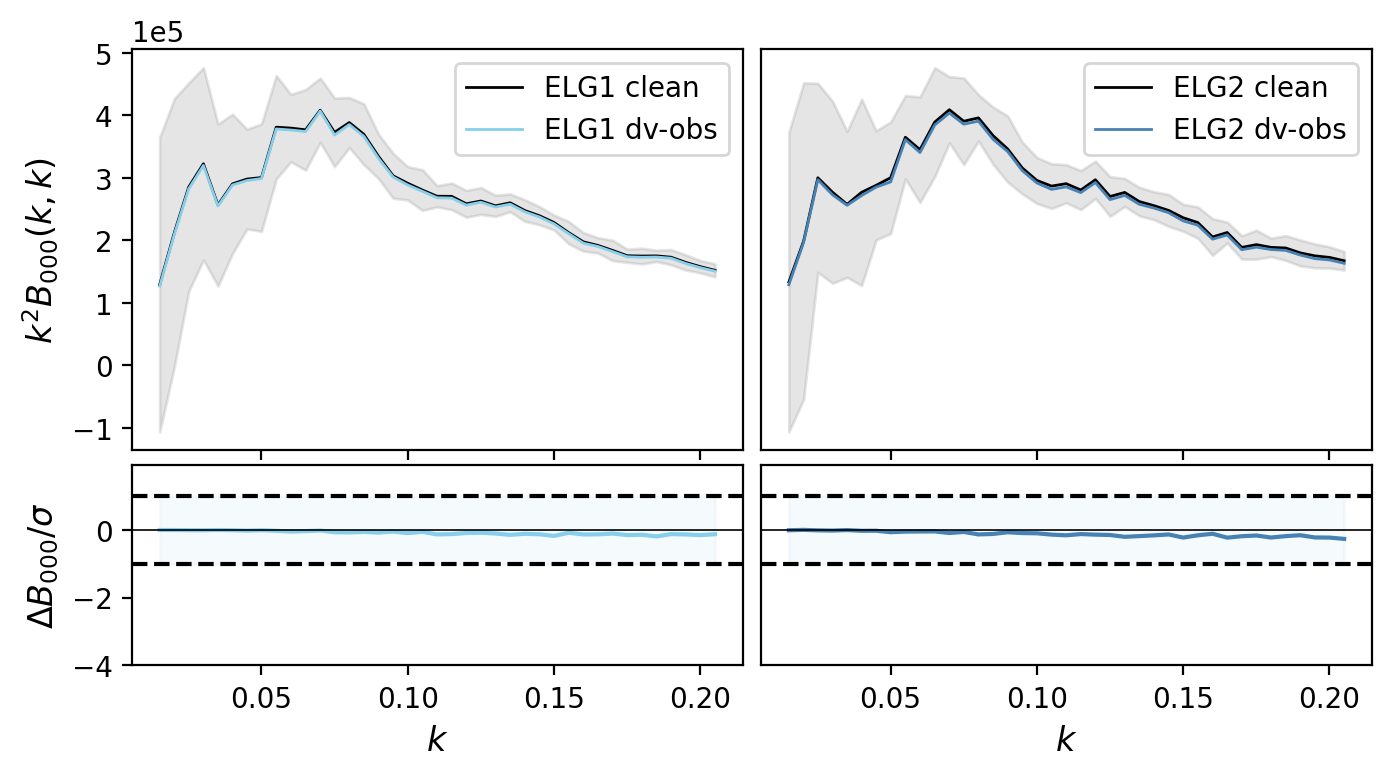

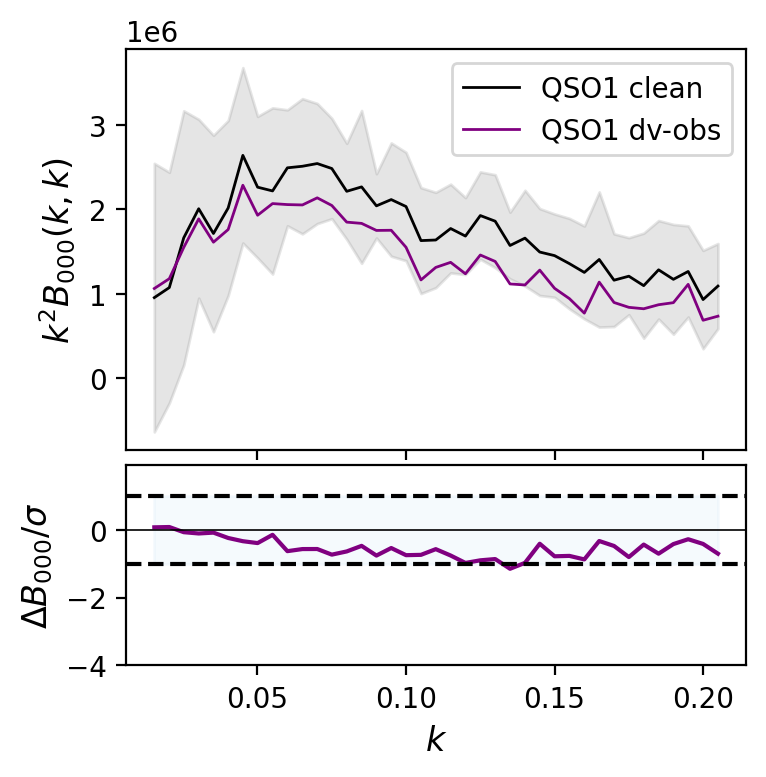

In [6]:
# PLOT THE BISPECTRUM
bins_type = 'test' # test, y3_bao

sys_models = ['standard','dv-obs']
tracers = ['BGS','LRG','ELG','QSO']
# tracers = ['LRG']

mockids = range(0,24)

Z_VSMEAR = REDSHIFT_LSS_VSMEAR
Z_CUBIC = REDSHIFT_LSS_CUBICBOX

for tracer in tracers:
    lenfig = len(Z_VSMEAR[tracer])
    if tracer == 'QSO':
        fig, ax = plt.subplots(2, lenfig, figsize = (lenfig*4,4), sharex=True, gridspec_kw={'height_ratios': [2,1]})
    else:
        fig, ax = plt.subplots(2, lenfig, figsize = (lenfig*4,4), sharex=True, gridspec_kw={'height_ratios': [2,1]})
    if lenfig == 1:
        ax = ax[:, np.newaxis]
    fig.subplots_adjust(wspace=0.03, hspace=0.05)
    for i,(zmin, zmax) in enumerate(Z_VSMEAR[tracer]):
        color = COLOR_TRACERS[tracer][i] 
        z_eff = REDSHIFT_CUBICBOX[tracer][i]
        data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "grid_cosmo": "000"}
        bk_dv_obs = []
        bk_standard = []
        for sys_model in sys_models:
            for mock_id in mockids:
                mock_id03 =  f"{mock_id:03}"
                base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                result_fn = base_dir+f'/bk000_diag_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npz'
                result = np.load(result_fn, allow_pickle=True)
                bk_raw = result["bk_raw"].real  # Real part of the raw bispectrum
                bk_shot = result["bk_shot"].real  # Real part of the shot noise
                bk = bk_raw - bk_shot
                k =  result["k1_eff"]
                k, bk = select_bk_range(k, bk, kmin=0.015, kmax=0.21)
                if sys_model in ['dv-obs']:
                    bk_dv_obs.append(bk)
                if sys_model in ['standard']:
                    bk_standard.append(bk)
        bk_standard = [np.mean(bk_standard, axis=0), np.std(bk_standard, axis=0)]
        bk_dv_obs = [np.mean(bk_dv_obs, axis=0), np.std(bk_dv_obs, axis=0)]
        # error_rsf = RSF_CUBIC_ERROR[tracer][i]
        # bk_standard_error = bk_standard[1]*error_rsf
        # error = bk_standard_error
        error = bk_standard[1]
        for t in range(2):
            if t == 0:
                ax[t][i].plot(k, k**2*bk_standard[0],color='black', lw=1.0, label = f'{tracer}{i+1} clean')
                ax[t][i].fill_between(k, k**2*(bk_standard[0]-error), k**2*(bk_standard[0]+error), color='grey', lw=1.0, alpha=0.2)
                ax[t][i].plot(k, k**2*bk_dv_obs[0],color=color, lw=1.0, label = f'{tracer}{i+1} dv-obs')
                ax[t][i].legend(loc=1, fontsize=10)
                # label = f'{tracer} z{zmin}-{zmax}'
                # line= Line2D([0], [0], label=label, color='none', alpha=0)
                # loc = 3
                # leg1 = ax[0][i].legend(handles=[line], loc=loc, fontsize=14)
                # leg1.get_frame().set_linewidth(0.0)
                # for text in leg1.get_texts():
                # text.set_color(color)
                if i ==0:
                    ax[t][i].set_ylabel(r"$k^2B_{000}(k,k)$")
                    ax[t][i].ticklabel_format(axis="y", style="sci", scilimits=(5, 6))
                # ax[t][i].set_xlim([0.05,0.205])
            if t == 1:
                ax[t][i].plot(k, (bk_dv_obs[0]-bk_standard[0])/error,color=color)
                if i ==0:
                    ax[t][i].set_ylabel(r'$\Delta B_{000}/\sigma$')
                ax[t][i].set_xlabel(r'$k$')
                ax[t][i].fill_between(k, -1 , 1, color = '#d1e7f7', alpha=0.2)
                ax[t][i].axhline(y=1, color = 'black', ls='--')
                ax[t][i].axhline(y=-1, color = 'black', ls='--')
                ax[t][i].axhline(y=0, color='black', lw=0.6)
                ax[t][i].set_ylim([-4,1.9])
                # if tracer == 'LRG':
                    # ax[t][i].set_ylim([-20,2])
            if i>0:
                ax[t][i].tick_params(axis='y', which='both', left=False, labelleft=False)

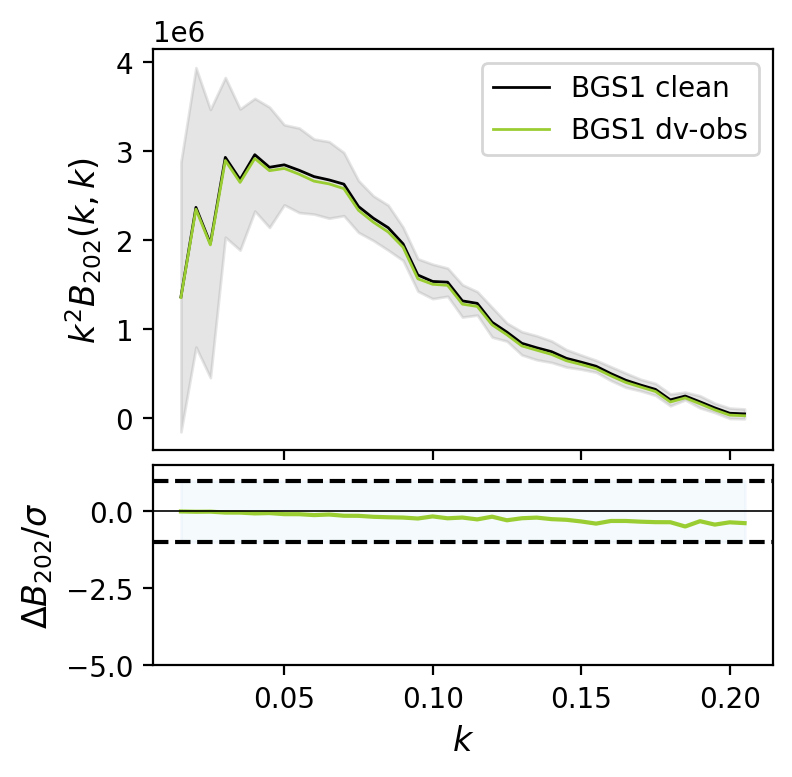

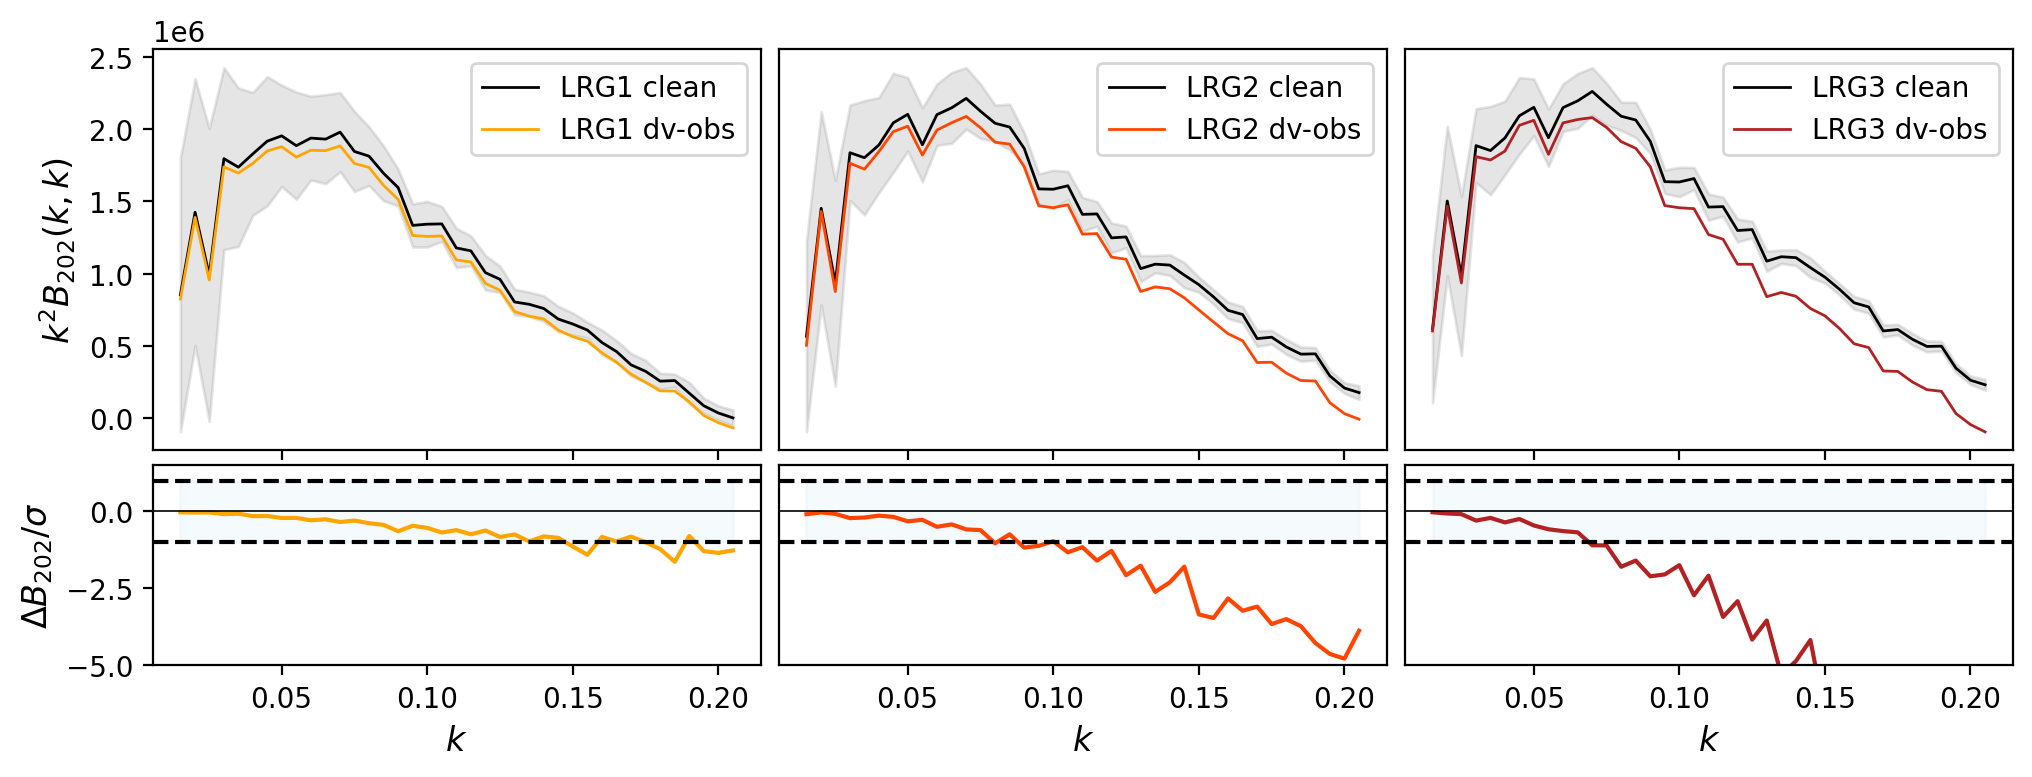

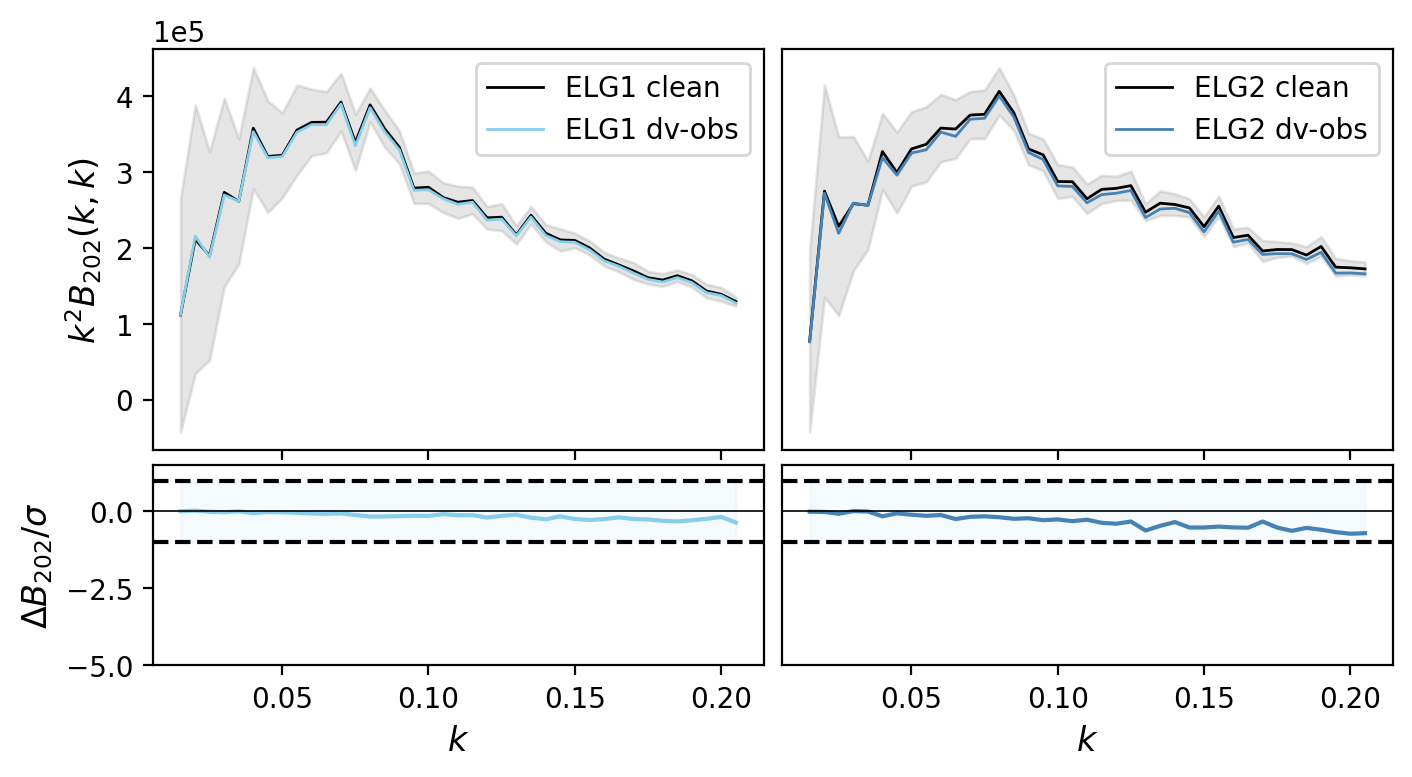

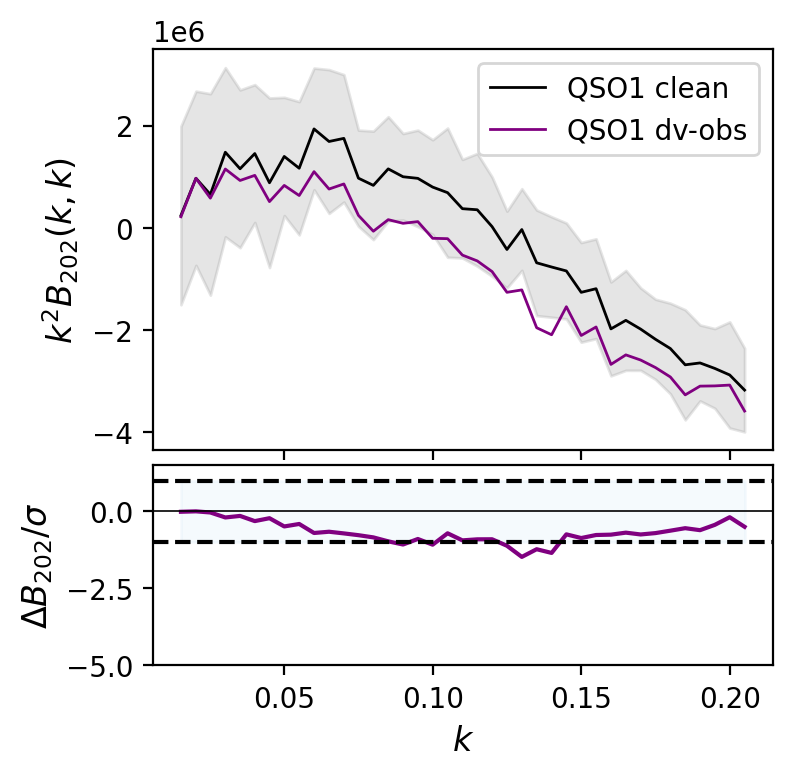

In [5]:
# PLOT THE BISPECTRUM
bins_type = 'test' # test, y3_bao

sys_models = ['standard','dv-obs']
tracers = ['BGS','LRG','ELG','QSO']
# tracers = ['LRG']

mockids = range(0,24)

Z_VSMEAR = REDSHIFT_LSS_VSMEAR
Z_CUBIC = REDSHIFT_LSS_CUBICBOX

for tracer in tracers:
    lenfig = len(Z_VSMEAR[tracer])
    if tracer == 'QSO':
        fig, ax = plt.subplots(2, lenfig, figsize = (lenfig*4,4), sharex=True, gridspec_kw={'height_ratios': [2,1]})
    else:
        fig, ax = plt.subplots(2, lenfig, figsize = (lenfig*4,4), sharex=True, gridspec_kw={'height_ratios': [2,1]})
    if lenfig == 1:
        ax = ax[:, np.newaxis]
    fig.subplots_adjust(wspace=0.03, hspace=0.05) 
    for i,(zmin, zmax) in enumerate(Z_VSMEAR[tracer]):
        color = COLOR_TRACERS[tracer][i] 
        z_eff = REDSHIFT_CUBICBOX[tracer][i]
        data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "grid_cosmo": "000"}
        bk_dv_obs = []
        bk_standard = []
        for sys_model in sys_models:
            for mock_id in mockids:
                mock_id03 =  f"{mock_id:03}"
                base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                result_fn = base_dir+f'/bk202_diag_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npz'
                result = np.load(result_fn, allow_pickle=True)
                bk_raw = result["bk_raw"].real  # Real part of the raw bispectrum
                # bk_shot = result["bk_shot"].real  # Real part of the shot noise
                # bk = bk_raw - bk_shot
                bk = bk_raw
                k =  result["k1_eff"]
                k, bk = select_bk_range(k, bk, kmin=0.015, kmax=0.21)
                if sys_model in ['dv-obs']:
                    bk_dv_obs.append(bk)
                if sys_model in ['standard']:
                    bk_standard.append(bk)
        bk_standard = [np.mean(bk_standard, axis=0), np.std(bk_standard, axis=0)]
        bk_dv_obs = [np.mean(bk_dv_obs, axis=0), np.std(bk_dv_obs, axis=0)]
        error_rsf = RSF_CUBIC_ERROR[tracer][i]
        bk_standard_error = bk_standard[1]*error_rsf
        error = bk_standard_error
        for t in range(2):
            if t == 0:
                ax[t][i].plot(k, k**2*bk_standard[0],color='black', lw=1.0, label = f'{tracer}{i+1} clean')
                ax[t][i].fill_between(k, k**2*(bk_standard[0]-error), k**2*(bk_standard[0]+error), color='grey', lw=1.0, alpha=0.2)
                ax[t][i].plot(k, k**2*bk_dv_obs[0],color=color, lw=1.0,  label = f'{tracer}{i+1} dv-obs')
                ax[t][i].legend(loc=1, fontsize=10)
                # label = f'{tracer} z{zmin}-{zmax}'
                # line= Line2D([0], [0], label=label, color='none', alpha=0)
                # loc = 3
                # leg1 = ax[0][i].legend(handles=[line], loc=loc, fontsize=14)
                # leg1.get_frame().set_linewidth(0.0)
                # for text in leg1.get_texts():
                #     text.set_color(color)
                if i ==0:
                    ax[t][i].set_ylabel(r"$k^2B_{202}(k,k)$")
                    ax[t][i].ticklabel_format(axis="y", style="sci", scilimits=(5, 6))
            if t == 1:
                ax[t][i].plot(k, (bk_dv_obs[0]-bk_standard[0])/error,color=color)
                if i ==0:
                    ax[t][i].set_ylabel(r'$\Delta B_{202}/\sigma$')
                ax[t][i].set_xlabel(r'$k$')
            if t ==1 or t==2:
                ax[t][i].fill_between(k, -1 , 1, color = '#d1e7f7', alpha=0.2)
                ax[t][i].axhline(y=1, color = 'black', ls='--')
                ax[t][i].axhline(y=-1, color = 'black', ls='--')
                ax[t][i].axhline(y=0, color='black', lw=0.6)
                ax[t][i].set_ylim([-5,1.5])
                # if tracer == 'LRG':
                    # ax[t][i].set_ylim([-20,2])
            if i>0:
                ax[t][i].tick_params(axis='y', which='both', left=False, labelleft=False)

ValueError: operands could not be broadcast together with shapes (27,) (3,) 

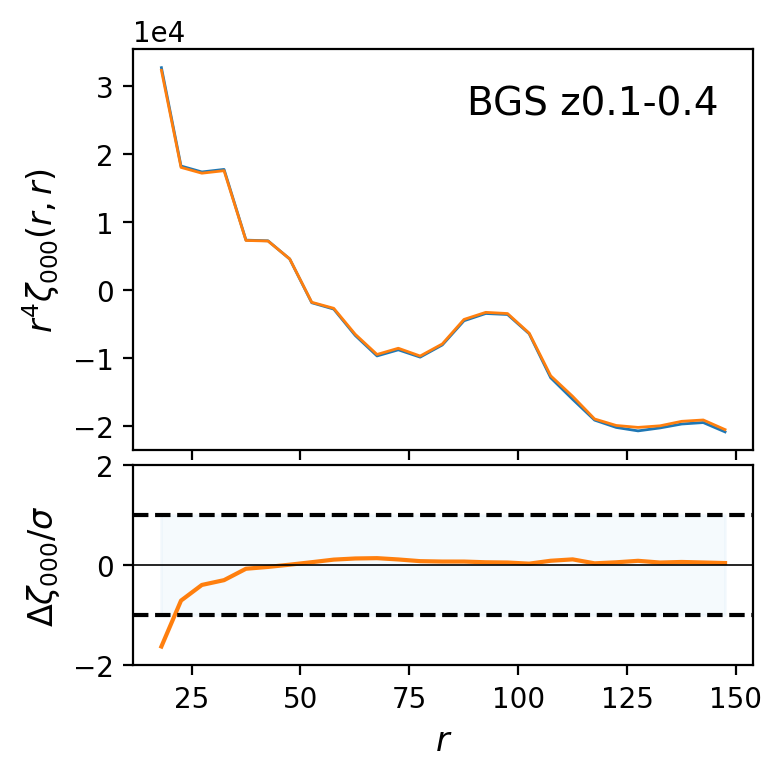

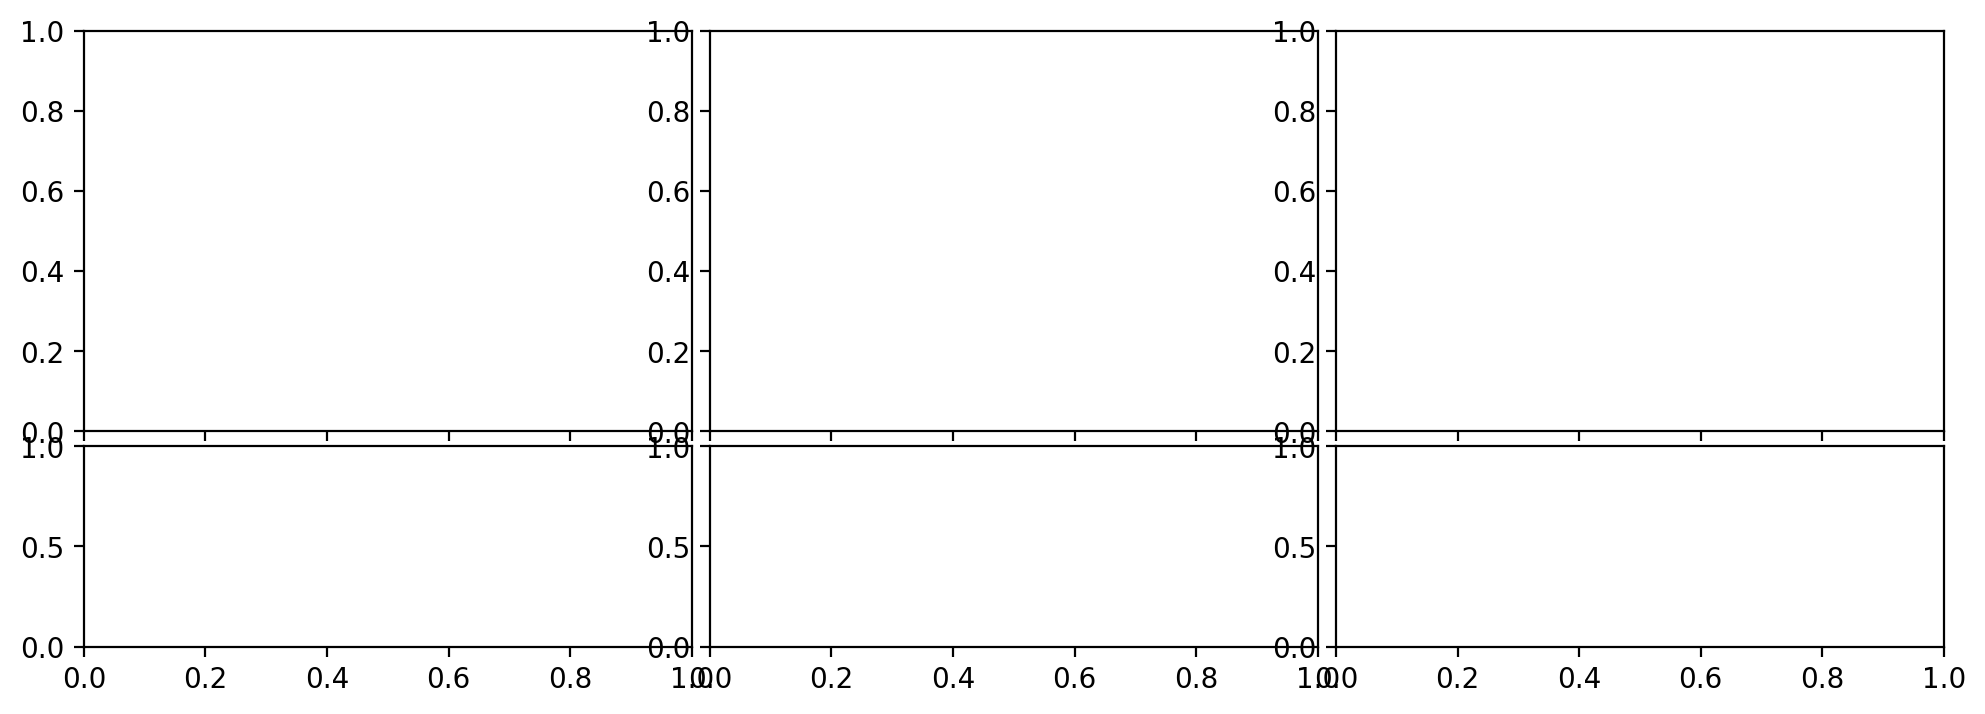

In [4]:
# PLOT THE 3PT
bins_type = 'test' # test, y3_bao

sys_models = ['standard','dv-obs']
tracers = ['BGS','LRG', 'ELG','QSO'] 
mockids = range(0,24)

for tracer in tracers:
    lenfig = len(Z_VSMEAR[tracer])
    if tracer == 'QSO':
        fig, ax = plt.subplots(2, lenfig, figsize = (lenfig*4,4), sharex=True, gridspec_kw={'height_ratios': [2,1]})
    else:
        fig, ax = plt.subplots(2, lenfig, figsize = (lenfig*4,4), sharex=True, gridspec_kw={'height_ratios': [2,1]})
    if lenfig == 1:
        ax = ax[:, np.newaxis] 
    fig.subplots_adjust(wspace=0.03, hspace=0.05) 
    for i,(zmin, zmax) in enumerate(Z_VSMEAR[tracer]):
        z_eff = Z_CUBIC[tracer][i]
        data_args = {"tracer": tracer, "z_eff": z_eff, "zmin": zmin, "zmax": zmax, "grid_cosmo": "000"}
        zeta_dv_obs = []
        zeta_standard = []
        for sys_model in sys_models:
            for mock_id in mockids:
                mock_id03 =  f"{mock_id:03}"
                base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/cosmosim/AbacusHOD_mocks_v1/CubicBox/{tracer}/obs_z{zmin:.1f}-{zmax:.1f}/AbacusSummit_base_c000_ph{mock_id03}/mpspk'
                result_fn = base_dir+f'/zeta000_diag_{tracer}_z{zmin:.1f}-{zmax:.1f}_{sys_model}.npz'
                result = np.load(result_fn, allow_pickle=True)
                zeta_raw = result["zeta_raw"].real  # Real part of the raw bispectrum
                zeta_shot = result["zeta_shot"].real  # Real part of the shot noise
                zeta = zeta_raw - zeta_shot
                r =  result["r1_eff"]
                zeta = zeta[3:]
                r = r[3:]
                if sys_model in ['dv-obs']:
                    zeta_dv_obs.append(zeta)
                if sys_model in ['standard']:
                    zeta_standard.append(zeta)
        zeta_standard = [np.mean(zeta_standard, axis=0), np.std(zeta_standard, axis=0)]
        zeta_dv_obs = [np.mean(zeta_dv_obs, axis=0), np.std(zeta_dv_obs, axis=0)]
        error_rsf = RSF_CUBIC_ERROR[tracer]
        zeta_standard_error = zeta_standard[1]*error_rsf
        error = zeta_standard_error
        for t in range(2):
            if t == 0:
                ax[t][i].plot(r, r**4*zeta_standard[0],color='C0', lw=1.0)
                ax[t][i].plot(r, r**4*zeta_dv_obs[0],color='C1', lw=1.0)
                label = f'{tracer} z{zmin}-{zmax}'
                line= Line2D([0], [0], label=label, color='none', alpha=0)
                loc = 1
                leg1 = ax[0][i].legend(handles=[line], loc=loc, fontsize=14)
                leg1.get_frame().set_linewidth(0.0)
                if i ==0:
                    ax[t][i].set_ylabel(r"$r^4\zeta_{000}(r,r)$")
                    ax[t][i].ticklabel_format(axis="y", style="sci", scilimits=(5, 6))
            if t == 1:
                ax[t][i].plot(r, (zeta_dv_obs[0]-zeta_standard[0])/error,color='C1')
                if i ==0:
                    ax[t][i].set_ylabel(r'$\Delta \zeta_{000}/\sigma$')
                ax[t][i].set_xlabel(r'$r$')
            if t ==1 or t==2:
                ax[t][i].fill_between(r, -1 , 1, color = '#d1e7f7', alpha=0.2)
                ax[t][i].axhline(y=1, color = 'black', ls='--')
                ax[t][i].axhline(y=-1, color = 'black', ls='--')
                ax[t][i].axhline(y=0, color='black', lw=0.6)
                ax[t][i].set_ylim([-2,2])
            if i>0:
                ax[t][i].tick_params(axis='y', which='both', left=False, labelleft=False)
